In [78]:
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from IPython.display import display
import numpy as np
from matplotlib import pyplot as plt

In [79]:
def rand_img(size):
    return np.random.randint(0, 256, size) / 255.0

In [80]:
def rand_sentence(len, max):
    return np.random.randint(0, max, len)

In [81]:
def one_hot_encoding(sentence, max):
    msg = np.zeros((len(sentence), max))
    for i, v in enumerate(sentence):
        msg[i, v] = 1
    return msg

In [82]:
def data_generator(image_size, sentence_len, sentence_max_word, batch_size=32):
    while True:
        x_img = np.zeros((batch_size, image_size[0], image_size[1], image_size[2]))
        x_sen = np.zeros((batch_size, sentence_len))
        y_img = np.zeros((batch_size, image_size[0], image_size[1], image_size[2]))
        y_sen = np.zeros((batch_size, sentence_len, sentence_max_word))
        for i in range(batch_size):
            img = rand_img(image_size)
            sentence = rand_sentence(sentence_len, sentence_max_word)
            sentence_one_hot_encoded = one_hot_encoding(sentence, sentence_max_word)
            x_img[i] = img
            x_sen[i] = sentence
            y_img[i] = img
            y_sen[i] = sentence_one_hot_encoded
        yield [x_img, x_sen], [y_img, y_sen]

In [83]:
def get_model(image_shape, sentence_len, max_word):
    input_img = Input(image_shape)
    input_sen = Input((sentence_len,))
    embed_sen = Embedding(max_word, 100)(input_sen)
    flat_emb_sen = Flatten()(embed_sen)
    flat_emb_sen = Reshape((image_shape[0], image_shape[1], 1))(flat_emb_sen)
    trans_input_img = Conv2D(20, 1, activation="relu")(input_img)
    enc_input = Concatenate(axis=-1)([flat_emb_sen, trans_input_img])
    out_img = Conv2D(3, 1, activation='relu', name='image_reconstruction')(enc_input)
    decoder_model = Sequential(name="sentence_reconstruction")
    decoder_model.add(Conv2D(1, 1, input_shape=(100, 100, 3)))
    decoder_model.add(Reshape((sentence_len, 100)))
    decoder_model.add(TimeDistributed(Dense(max_word, activation="softmax")))
    out_sen = decoder_model(out_img)
    model = Model(inputs=[input_img, input_sen], outputs=[out_img, out_sen])
    model.compile('adam', loss=[mean_absolute_error, categorical_crossentropy],
                  metrics={'sentence_reconstruction': categorical_accuracy})
    encoder_model = Model(inputs=[input_img, input_sen], outputs=[out_img])
    return model, encoder_model, decoder_model


In [84]:
def ascii_encode(message, sentence_len):
    sen = np.zeros((1, sentence_len))
    for i, a in enumerate(message.encode("ascii")):
        sen[0, i] = a
    return sen

In [85]:
def ascii_decode(message):
    return ''.join(chr(int(a)) for a in message[0].argmax(-1))

In [86]:
def main():
    image_shape = (100, 100, 3)
    sentence_len = 100
    max_word = 256
    gen = data_generator(image_shape, sentence_len, max_word, 64)
    model, encoder, decoder = get_model(image_shape, sentence_len, max_word)
    try:
        model.load_weights("best_weights.h5")
    except:
        model.fit(gen, epochs=10, steps_per_epoch=100, callbacks=[
            ModelCheckpoint("best_weights.h5",monitor="loss",
                            verbose=1,
                            save_weights_only=True,
                            save_best_only=True)]
        )
    
    img_temp = Image.open("../input/random-images/image.jpg")
    res = img_temp.resize((100, 100))
    img = np.expand_dims(img_to_array(res) / 255.0, axis=0)
    
    
    text_to_encode = input("Enter the code you want to encode: ")
    sen = ascii_encode(text_to_encode, sentence_len)
    
    print("The image in which your message will be encoded will be shown  now")
    plt.imshow(img[0], interpolation='nearest')
    plt.show()


    y = encoder.predict([img, sen])
    print("The encoded image will be shown now")
    plt.imshow(y[0], interpolation='nearest')
    plt.show()
    
    y_hat = decoder.predict(y)
    print("The decrypted message is: ", ascii_decode(y_hat))

Enter the code you want to encode:  Hello Hello


The image in which your message will be encoded will be shown  now


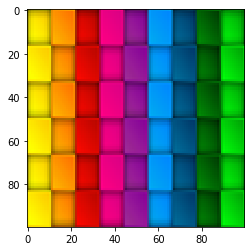

The encoded image will be shown now


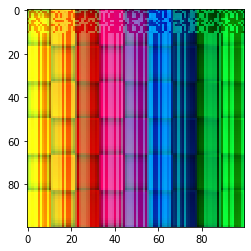

The decrypted message is:  Hello Hello                                                                                         


In [87]:
if __name__ == "__main__":
    main()